In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pickle
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import seaborn as sns
import scipy
from matplotlib import cm
import copy
%matplotlib inline

import sys
import plotting_functions
from tsne_plotting_functions import plot_continuous_tsne, plot_categorical_tsne


/home/nbbwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load data

In [2]:
path_to_labels_folder = "../../DATA/External_Validation/"
path_to_MDAD_labels = "../../DATA/MTL_data/labels.csv"

path_to_preds_folder = "../../Pipeline_Outputs_Submitted/External_Validation/"
path_to_MDAD_finalmodel_preds =  "../../Pipeline_Outputs_Submitted/final_model/MDAD_predictions/0.hdf5"

# This should point to the embedding from a single run (run 0) to match up with what we have for the test set
path_to_MDAD_finalmodel_emb = "../../Pipeline_Outputs_Submitted/model_transformations/MTL/1/0.txt"

phenotypes = ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]

In [3]:
label_dfs = {}
embedding_dfs = {}
predictions_dfs = {}

for dset,dpath in [("Mouse", "_intersection"), ("all_human",""),
                   ("Blood_GSE63060","_intersection"), ("Blood_GSE63061","_intersection")]:
    
    label_dfs[dset] = {}
    embedding_dfs[dset] = {}
    predictions_dfs[dset] = {}
    
    label_dfs[dset]["test"] = pd.read_csv("%sCleaned/Model_Predictions/MTL/%s.csv"%(path_to_preds_folder,dset))
    label_dfs[dset]["train"] = pd.read_csv(path_to_MDAD_labels)
    
    predictions_dfs[dset]["test"] = pd.read_csv("%sCleaned/Model_Predictions/MTL/%s.csv"%(path_to_preds_folder,dset))
    
    if dpath=="":
        preds=[]
        with h5py.File(path_to_MDAD_finalmodel_preds, 'r') as hf:
            for phenotype in phenotypes:
                preds.append(hf[phenotype][:])
        predictions_dfs[dset]["train"] = pd.DataFrame(np.mean(np.array(preds),axis=2).T, columns=phenotypes)
        embedding_dfs[dset]["train"] = np.loadtxt(path_to_MDAD_finalmodel_emb)

    else:
        predictions_dfs[dset]["train"] = pd.read_csv("%spredictions%s/%s/MTL/final_train.csv"%(path_to_preds_folder,dpath,dset), index_col=0)
        embedding_dfs[dset]["train"] = np.loadtxt("%smodel_transformations%s/%s/MTL/1/train/0.txt"%(path_to_preds_folder, dpath,dset))

    
    embedding_dfs[dset]["test"] = np.loadtxt("%sCleaned/test_embeddings/MTL/%s.csv"%(path_to_preds_folder, dset))

    for mode in ["test", "train"]:
        predictions_dfs[dset][mode]["AB_RELATED"] = np.mean(predictions_dfs[dset][mode][["ABETA_IHC", "PLAQUES", "CERAD"]].rank(pct=True),axis=1)
        predictions_dfs[dset][mode]["TAU_RELATED"] = np.mean(predictions_dfs[dset][mode][["TAU_IHC", "TANGLES", "BRAAK"]].rank(pct=True),axis=1)
        predictions_dfs[dset][mode]["AVG"] = np.mean(predictions_dfs[dset][mode][["AB_RELATED", "TAU_RELATED"]].rank(pct=True),axis=1)

# Select external dataset to plot

In [4]:
dset = "Mouse" # Other options:  "Blood_GSE63061",  "Blood_GSE63060", "Mouse"

calc_new = False
nangray = True

cmap=plt.cm.tab10
cmaplist = [cmap(i) for i in range(cmap.N)]

In [5]:
if not os.path.isdir(path_to_preds_folder + "FinalEmbeddings_tsne_transformed/"):
    os.makedirs(path_to_preds_folder + "FinalEmbeddings_tsne_transformed/")

In [6]:
### CALCULATE NEW T-SNE EMBEDDINGS OR LOAD PREVIOUSLY COMPUTED ONES 
allsamples = np.vstack([embedding_dfs[dset]["train"], embedding_dfs[dset]["test"]])
non_triv_idx = np.where(np.sum(np.abs(allsamples),axis=0))[0]

if calc_new:
    #only need to run this the first time:
    tsne = TSNE(n_components=2, perplexity=30)
    E = tsne.fit_transform(allsamples[:,non_triv_idx])
    np.savetxt("%sFinalEmbeddings_tsne_transformed/tsne_embedding_%s.txt"%(path_to_preds_folder,dset), E)
else:
    E = np.loadtxt("%sFinalEmbeddings_tsne_transformed/tsne_embedding_%s.txt"%(path_to_preds_folder,dset))

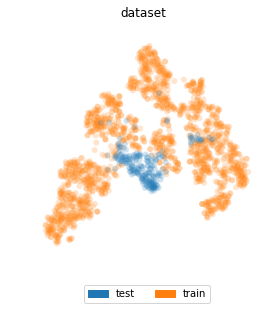

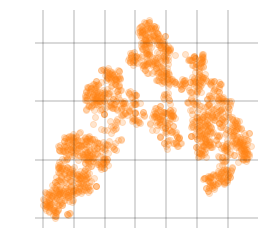

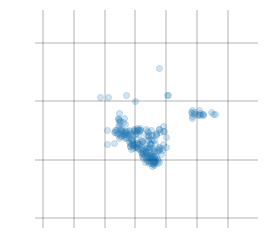

In [7]:
phen = "dataset"
phens = np.hstack([["train"]*len(embedding_dfs[dset]["train"]), ["test"]*len(embedding_dfs[dset]["test"])])
cmap = "tab20"
nangray = True

plot_categorical_tsne(E, phens, phen, "tab10", nangray, alpha=.2)

# just brain data:
xlims = [np.min(E[:,0])-5, np.max(E[:,0])+5]
ylims = [np.min(E[:,1])-5, np.max(E[:,1])+5]

for mode in ["train", "test"]:
    train_size = len(embedding_dfs[dset]["train"])
    f,axes = plt.subplots(1,1,figsize=(4,4))
    axes.vlines(np.arange(xlims[0]+5,xlims[1],20), ylims[0], ylims[1], alpha=.2)
    axes.hlines(np.arange(ylims[0]+5,ylims[1],30), xlims[0], xlims[1], alpha=.2)
    if mode == "train":
        axes.scatter(E[:train_size][:,0], E[:train_size][:,1], c = cmaplist[1], alpha=.2)
    else:
        axes.scatter(E[train_size:][:,0], E[train_size:][:,1], c = cmaplist[0], alpha=.2)
    axes.axis('off')
    axes.set_ylim(ylims)
    axes.set_xlim(xlims)
    axes.set_facecolor('None')


In [8]:
plotting_labels = {}
    
for train_val, test_val in [("real", "real"), ("real", "pred"), ("pred", "real"), ("pred", "pred")]:

    if test_val == "pred":

        # all MD-AD predicted labels 
        if train_val == "pred":
            cols = predictions_dfs[dset]["train"].columns
            tmp_test_preds = predictions_dfs[dset]["test"][predictions_dfs[dset]["train"].columns]
            preds = np.vstack([predictions_dfs[dset]["train"], tmp_test_preds])
            plot_labels = pd.DataFrame(preds, columns=cols)

        # real labels for training samples, predicted labels for test set
        else:
            tr_labels_scale = label_dfs[dset]["train"][phenotypes]
            for p in ["CERAD", "BRAAK"]:
                tr_labels_scale[p] = tr_labels_scale[p].astype(float)/np.max(tr_labels_scale[p].astype(float))
            real_preds = np.vstack([tr_labels_scale, predictions_dfs[dset]["test"][phenotypes]])
            plot_labels =  pd.DataFrame(real_preds, columns=phenotypes)
    # for "real" test values, we'll estimate them based on cogntive status/AD status/strain
    else:

        if dset in ["Blood_GSE63060", "Blood_GSE63061"]:
            test_status_array = label_dfs[dset]["test"]["status"].apply(lambda x: .2 if x=="CTL" else .8).values
        elif dset == "Mouse":
            test_status_array = label_dfs[dset]["test"]["strain"].apply(lambda x: .8 if x=="HO_TASTPM" else (.6 if x=="HET_TASTPM" else (.2 if x=="WILD" else np.nan))).values
        else:
            test_status_array = label_dfs[dset]["test"]["AD"].apply(lambda x: .8 if x==1 else (.2 if x==0 else np.nan)).values


        # real traning and real test labels (test labels will be estimated based on cognitive status/AD status/strain)
        if train_val == "real":
            tr_labels_scale = label_dfs[dset]["train"][phenotypes]
            for p in ["CERAD", "BRAAK"]:
                tr_labels_scale[p] = tr_labels_scale[p].astype(float)/np.max(tr_labels_scale[p].astype(float))

            status_matrix = np.vstack([test_status_array]*tr_labels_scale.shape[1]).T
            real_real_vals = np.vstack([tr_labels_scale, status_matrix])
            plot_labels =   pd.DataFrame(real_real_vals, columns=phenotypes)

        # predicted train labels, real test labels
        else:

            status_matrix = np.vstack([test_status_array]*predictions_dfs[dset]["train"].shape[1]).T
            pred_real_vals =  np.vstack([predictions_dfs[dset]["train"].values, status_matrix])
            plot_labels =  pd.DataFrame(pred_real_vals, columns=predictions_dfs[dset]["train"].columns)                                    

    plotting_labels[(train_val, test_val)] = plot_labels


/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/home/nbbwang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


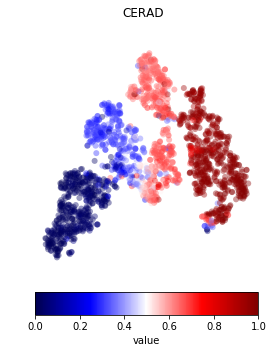

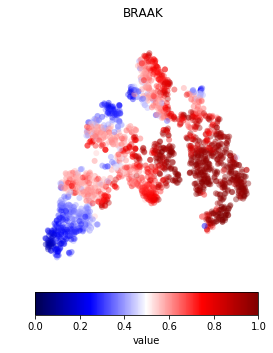

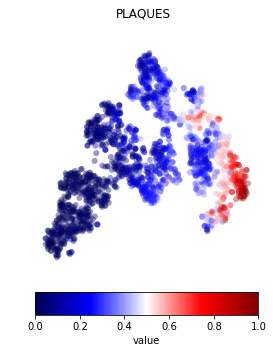

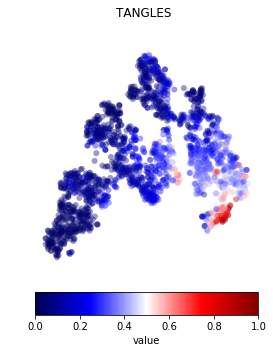

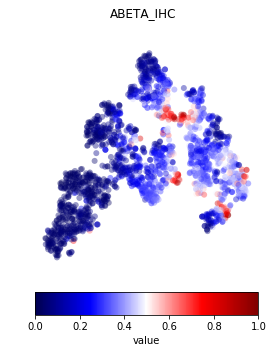

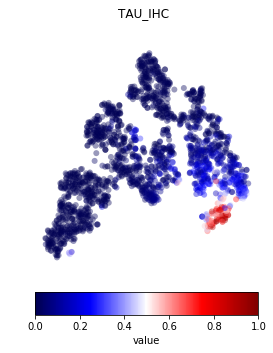

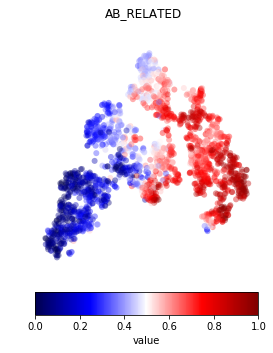

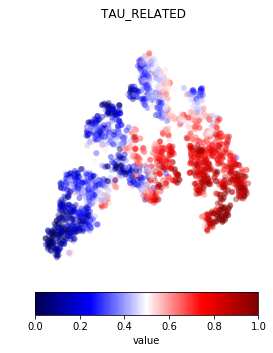

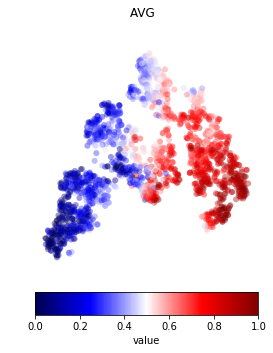

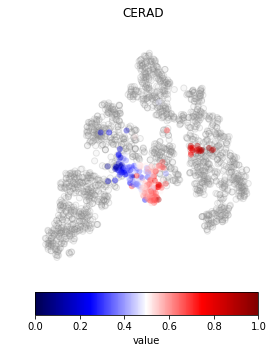

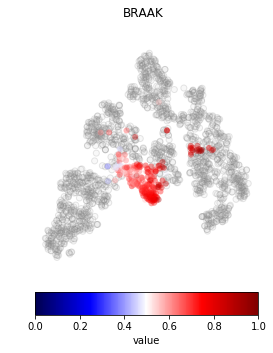

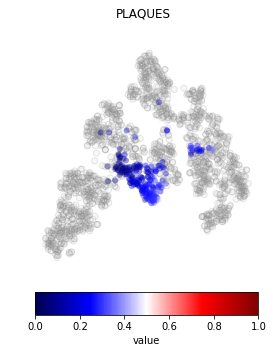

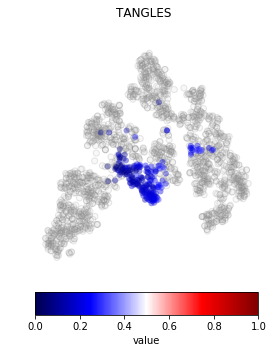

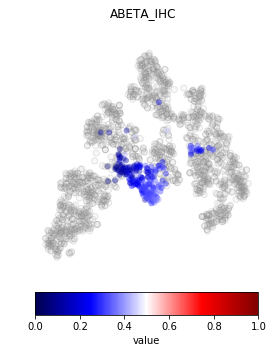

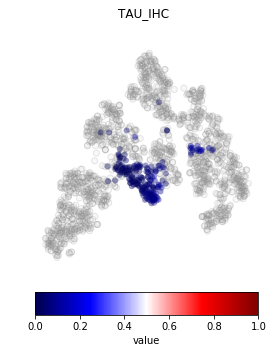

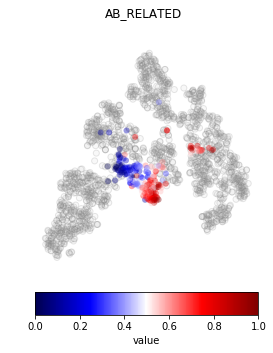

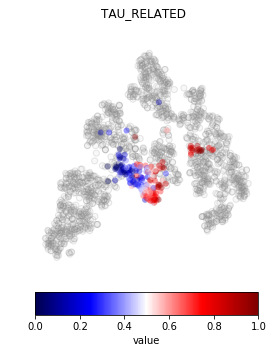

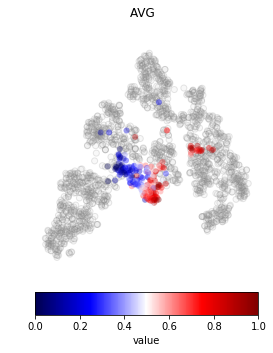

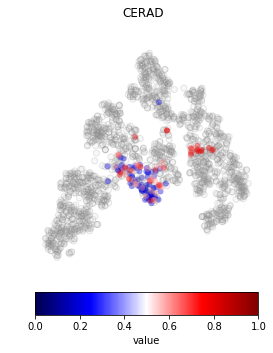

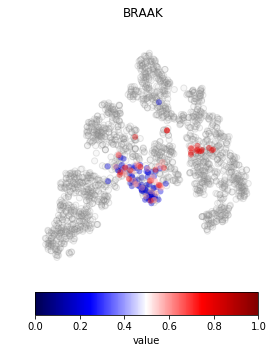

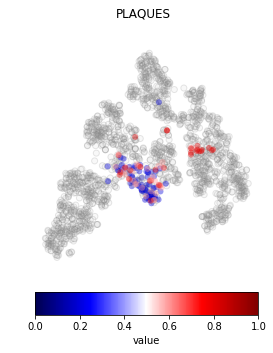

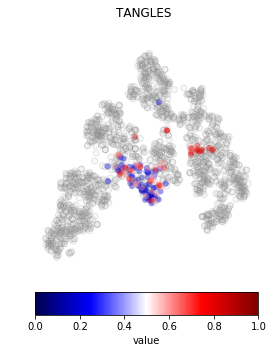

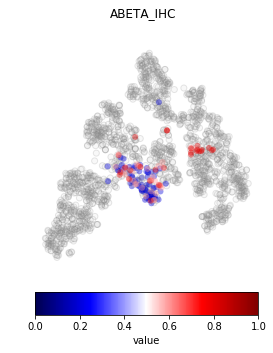

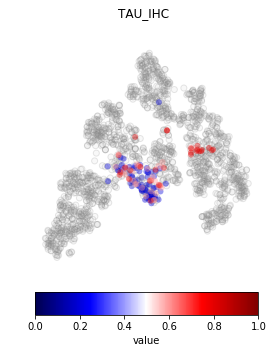

In [9]:
# GENERATE PLOTS WE WANT

for (train_val, test_val, hide_tr) in [("pred","pred", False),("pred","pred", True), ("real","real", True)]:
    
    unsupervised_dim = 50

    if train_val == "pred":
        phens_to_plot = ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC", "AB_RELATED","TAU_RELATED","AVG"]
    else:
        phens_to_plot = ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]


    for i,phen in enumerate(phens_to_plot):

        phens = copy.copy(plotting_labels[(train_val, test_val)][phen].values)

        phens_s = phens.astype(str)

        if phen in phens_to_plot: 
            if hide_tr:
                phens[:train_size] = np.nan

            plot_continuous_tsne(E, phens, phen, matplotlib.cm.seismic, nangray, lims=(0,1))

        elif len(np.unique(phens_s[phens_s != "nan"])) < 4:
            plot_categorical_tsne(E, phens, phen, "tab10", nangray)

        else:
            if hide_tr:
                phens[:train_size] = np.nan

            plot_continuous_tsne(E, phens, phen, matplotlib.cm.seismic, nangray, lims=(0,1))


### special plots for mouse:

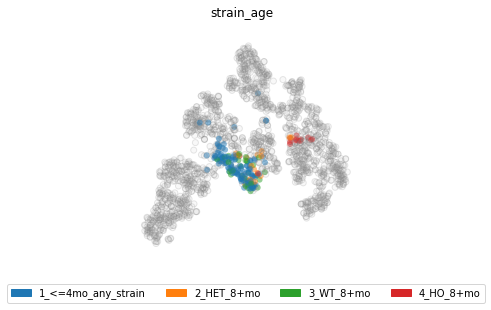

In [10]:
nangray = True
cmap = "tab10"

age_temp = label_dfs[dset]['test']["age"].apply(lambda x: "_8+mo" if x == "18months" else "_8+mo" if x=="8months" else "_<=4mo" if x=="4months" else "_<=4mo")
strain_temp = label_dfs[dset]['test']["strain"].apply(lambda x: x if x in ["HET_TASTPM","HO_TASTPM","WILD"] else "other")

test_labs = strain_temp + age_temp
test_labs = test_labs.apply(lambda x: "1_<=4mo_any_strain" if "<=4mo" in x else (
                                        "3_WT_8+mo" if "WILD" in x else (
                                        "4_HO_8+mo" if "HO_TASTPM" in x else (
                                        "2_HET_8+mo" if "HET_TASTPM" in x else np.nan))))

phens = np.hstack([[np.nan]*len(embedding_dfs[dset]["train"]), test_labs])

rand_order = np.arange(len(phens))
np.random.shuffle(rand_order)
plot_categorical_tsne(E[rand_order], phens[rand_order], "strain_age", cmap, nangray, alpha=.5)